Epoch 1/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 53s 265ms/step - loss: 0.0257 - val_loss: 0.0068
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 58s 298ms/step - loss: 0.0064 - val_loss: 0.0054
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 74s 380ms/step - loss: 0.0053 - val_loss: 0.0048
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 58s 297ms/step - loss: 0.0048 - val_loss: 0.0044
Epoch 5/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 56s 283ms/step - loss: 0.0045 - val_loss: 0.0041
Epoch 6/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 62s 316ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 7/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 65s 331ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 8/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 57s 292ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 9/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 57s 292ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 10/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 57s 289ms/step - loss: 0.0035 - val_loss: 0.0035
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


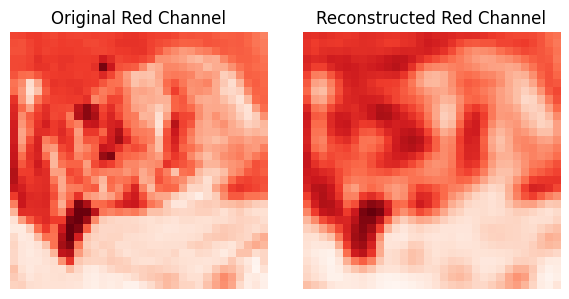

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
import numpy as np
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

# Load CIFAR-10 dataset and normalize it
(x_train, _), (x_test, _) = cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Extract only the red channel for training and testing
x_train_red = x_train[:, :, :, 0:1]  # Single channel (red) for training
x_test_red = x_test[:, :, :, 0:1]  # Single channel (red) for testing

# Define the encoder
input_img = Input(shape=(32, 32, 1))  # Single-channel input
x = Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
encoded = MaxPooling2D((2, 2), padding="same")(x)

# Define the decoder
x = Conv2D(32, (3, 3), activation="relu", padding="same")(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation="sigmoid", padding="same")(
    x
)  # Single-channel output

# Compile the autoencoder
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer="adam", loss="mean_squared_error")

# Train the autoencoder
autoencoder.fit(
    x_train_red,
    x_train_red,
    epochs=10,
    batch_size=256,
    shuffle=True,
    validation_data=(x_test_red, x_test_red),
)

# Visualize some outputs
# Select a sample test image
test_image = x_test_red[:1]

# Get reconstructed image
reconstructed_image = autoencoder.predict(test_image)

# Plot the original and reconstructed images
plt.figure(figsize=(6, 3))

# Original Red Channel Image
plt.subplot(1, 2, 1)
plt.imshow(test_image[0, :, :, 0], cmap="Reds")
plt.title("Original Red Channel")
plt.axis("off")

# Reconstructed Red Channel Images
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image[0, :, :, 0], cmap="Reds")
plt.title("Reconstructed Red Channel")
plt.axis("off")

plt.tight_layout()
plt.show()

In [6]:
autoencoder.save('./models/red_autoencoder.keras')

## Fine tune to include additional 2 dimensions

In [7]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.datasets import cifar10

# Load the single-channel (red) autoencoder model
autoencoder = load_model("./models/red_autoencoder.keras")

# Modify the input to accept 3 channels (RGB)
input_img = Input(shape=(32, 32, 3))  # RGB input with 3 channels

# Rebuild the encoder with 3-channel input
x = Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
encoded = MaxPooling2D((2, 2), padding="same")(x)

# Rebuild the decoder with 3-channel output
x = Conv2D(32, (3, 3), activation="relu", padding="same")(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation="sigmoid", padding="same")(
    x
)  # RGB output with 3 channels

# Create the new RGB autoencoder model
rgb_autoencoder = Model(input_img, decoded)

# Compile the model
rgb_autoencoder.compile(optimizer="adam", loss="mean_squared_error")

# Load CIFAR-10 dataset and normalize it
(x_train, _), (x_test, _) = cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Fine-tune the model on full RGB data
rgb_autoencoder.fit(
    x_train,
    x_train,
    epochs=5,  # Fewer epochs for fine-tuning
    batch_size=256,
    shuffle=True,
    validation_data=(x_test, x_test),
)

# Save the updated RGB autoencoder model
rgb_autoencoder.save("./models/rgb_autoencoder.keras")

Epoch 1/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 68s 341ms/step - loss: 0.0276 - val_loss: 0.0085
Epoch 2/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 71s 361ms/step - loss: 0.0079 - val_loss: 0.0075
Epoch 3/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 68s 345ms/step - loss: 0.0066 - val_loss: 0.0060
Epoch 4/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 65s 332ms/step - loss: 0.0060 - val_loss: 0.0055
Epoch 5/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 65s 329ms/step - loss: 0.0056 - val_loss: 0.0052


## Same idea different method

In [12]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt

# Load the single-channel (red) autoencoder model
red_autoencoder = load_model("./models/red_autoencoder.keras")

# Define a new input layer with 3 channels (for RGB)
input_img = Input(shape=(32, 32, 3))

# First Conv2D layer
conv1 = Conv2D(32, (3, 3), activation="relu", padding="same")
x = conv1(input_img)
conv1_weights = red_autoencoder.layers[1].get_weights()
# Repeat red weights across 3 input channels (single RGB image) correctly for Conv2D format
conv1_weights[0] = (
    np.tile(conv1_weights[0], (1, 1, 3, 1)) / 3
)  # average for balanced start
conv1.set_weights(conv1_weights)
x = MaxPooling2D((2, 2), padding="same")(x)

# Second Conv2D layer
conv2 = Conv2D(32, (3, 3), activation="relu", padding="same")
x = conv2(x)
conv2_weights = red_autoencoder.layers[3].get_weights()
conv2.set_weights(conv2_weights)  # Direct copy since the shape should match
x = MaxPooling2D((2, 2), padding="same")(x)

# Third Conv2D layer in decoder
conv3 = Conv2D(32, (3, 3), activation="relu", padding="same")
x = conv3(x)
conv3_weights = red_autoencoder.layers[5].get_weights()
conv3.set_weights(conv3_weights)
x = UpSampling2D((2, 2))(x)

# Fourth Conv2D layer in decoder
conv4 = Conv2D(32, (3, 3), activation="relu", padding="same")
x = conv4(x)
conv4_weights = red_autoencoder.layers[7].get_weights()
conv4.set_weights(conv4_weights)
x = UpSampling2D((2, 2))(x)

# Final Conv2D layer to produce RGB output
output_layer = Conv2D(3, (3, 3), activation="sigmoid", padding="same")
decoded = output_layer(x)

# Get the original weights of the output layer from the red autoencoder
output_weights = red_autoencoder.layers[9].get_weights()

# Properly tile only the kernel weights to match (3, 3, 32, 3)
output_weights[0] = np.tile(output_weights[0], (1, 1, 1, 3)) / 3

# Set the weights for the output layer (kernel and bias)
output_layer.set_weights(output_weights)


# Create the new RGB autoencoder model
rgb_autoencoder = Model(input_img, decoded)

# Compile the RGB model
rgb_autoencoder.compile(optimizer="adam", loss="mean_squared_error")

# Load CIFAR-10 dataset and normalize it
(x_train, _), (x_test, _) = cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Fine-tune the model on full RGB data
rgb_autoencoder.fit(
    x_train,
    x_train,
    epochs=5,  # Fewer epochs since we are fine-tuning
    batch_size=256,
    shuffle=True,
    validation_data=(x_test, x_test),
)

# Save the fine-tuned RGB autoencoder model
rgb_autoencoder.save("./models/rgb_autoencoder_finetuned.keras")

# Visualization of results
# Select a sample test image
test_image = x_test[:1]
reconstructed_image = rgb_autoencoder.predict(test_image)

# Plot the original and reconstructed images
plt.figure(figsize=(6, 3))

# Original RGB Image
plt.subplot(1, 2, 1)
plt.imshow(test_image[0])
plt.title("Original RGB Image")
plt.axis("off")

# Reconstructed RGB Image
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image[0])
plt.title("Reconstructed RGB Image")
plt.axis("off")

plt.tight_layout()
plt.show()

ValueError: Layer conv2d_26 weight shape (3,) is not compatible with provided weight shape (1,).